## 3 Modelling

In this notebook, we take the formatted data from our [EDA Notebook](P3-2_PP_EDA.ipynb) and feed the results into a number of various vectorizer/model pairs. [MLFlow](P3_Run_mlops.ipynb) was used to track the performance of the models. The packages used (from sklearn) are as follows:

**Vectorizers:**
1. Count Vectorization
2. TF-IDF Vectorization

**Classifier Models:**
1. Naive Bayes
2. Logistic Regression
3. Random Forest
4. Extra Trees

Each combination is run for a total of 8 models evaluated. Some level of hyperparameter tuning will be run, trying to balance iterating through a robust set of variables while maintaining reasonable computational time. A brief summary of which parameters are chosen for hyperparameter tuning are as follows:

Note: This is the second, more streamlined iteration of hyperparameter tuning, and some hyperparameters were removed in the interest of time (*evaluated in a [previous version](P3-3_Model_Basic.ipynb)*). The parameters that were identified to always be ignored as best_parameters across most (*if not all*) models were removed from the final model evaluation.

**Vectorizers:**
1. max_features: (15,000, 20,000, 30,000) (*excluded: <15,000*)
2. min_df: (0.0001, 0.001, 0.1, 1)
3. max_df: (0.7, 0.8, 0.9, 1)
4. ngram_range: Unigrams (*excluded: Bigrams, Trigrams*)

**Classifier Models:**
1. (NB), alpha: (0.001, 0.1, 1, 10, 100)
2. (LR), penalty: (l2) (*excluded: l1, elasticnet*)
3. (LR), solver: (liblinear, saga) (*excluded: other solvers*)
4. (LR), max_iter: (10000)
5. (LR, SVC),C: (0.0001, 0.001, 0.01, 0.1, 1)
3. (Decision Trees), estimators: (100,125,150)
7. (Decision Trees), max_depth': (50) (*excluded: 10,25*)


In [1]:
# Base Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For Web Scraping
from bs4 import BeautifulSoup
import requests

# For Pre-Processing/Word Cleaning
import re, nltk, string
import demoji
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# For Modelling
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# Miscellaneous
import time
from tqdm.notebook import tqdm
import mlflow

In [2]:
# Setting ml-flow to track metrics
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("P3_reddit-SCIvPHILO")
mlflow.autolog()

2022/10/12 14:17:34 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2022/10/12 14:17:34 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


### 3.0.1 Functions

In [14]:
# Function to print relevant metrics
def print_metrics(model,model_name,X_test,y_test):
    y_pred = model.predict(X_test)
    print(f'Accuracy: {accuracy_score(y_test,y_pred)}')
    print(f'Recall: {recall_score(y_test,y_pred, pos_label = "science")}')
    print(f'Precision: {precision_score(y_test,y_pred, pos_label = "science")}')
    print(f'F1 Score: {f1_score(y_test,y_pred, pos_label = "science")}')
    
    # Plotting Confusion Matrix
    cm = confusion_matrix(y_test,y_pred)
    
    # Depending on python environment, run one or the other
    # plot_confusion_matrix(model, X_test, y_test, cmap = 'Greens', display_labels = ['Philosophy','Science'])
    ConfusionMatrixDisplay.from_predictions(y_test,y_pred, cmap = 'Greens')
    
    plt.title(f'{model_name} Confusion Matrix', fontsize = 14);
    

In [4]:
# vectorizer dictionary
vect_dict = {'cvec': 'CountVectorizer',
             'tvec': 'TfidfVectorizer'}

# model dictionary
model_dict = {'nb': 'MultinomialNB', # Multinomial Naive Bayes
              'lr': 'LogisticRegression', # Logistic Regression
              'rf': 'RandomForestClassifier', # Random Forest
              'et': 'ExtraTreesClassifier', # Extra Trees
              'gb': 'GradientBoostingClassifier', # Gradient-Boosting Classifier
              'svc':'SVC'} # Support Vector Classifier


In [13]:
# ------------------------------------------------------------------------------------------------------
# VECTORIZER PARAMETERS FOR HYPERTUNING
# ------------------------------------------------------------------------------------------------------
# The tuning parameters selected based on basic model sensing
def vector_params(vectorizer):
    vec_params = {vectorizer+'__max_features': [15_000, 20_000, 30_000],
                  vectorizer+'__min_df': [0.0001, 0.001, 0.1, 1], 
                  vectorizer+'__max_df': [0.7, 0.8, 0.9, 1],
                  vectorizer+'__ngram_range': [(1, 1)]} # 1-gram is almost always the best
    return vec_params

# ------------------------------------------------------------------------------------------------------
# MODEL PARAMETERS FOR HYPERTUNING
# ------------------------------------------------------------------------------------------------------
def model_params(model):
    # Naive Bayes
    if model == 'nb': mod_params = {'nb__alpha': [0.001, 0.1, 1, 10, 100]}
    
    # Logistic Regression
    elif model == 'lr': mod_params = {'lr__penalty': ['l2'], # l2 almost always best
                                      'lr__solver': ['liblinear','saga'],
                                      'lr__max_iter': [10000],
                                      'lr__C': [0.0001, 0.001, 0.01, 0.1, 1]}
    
    #Decision Tree Models
    elif model in ['rf','et','gb']: mod_params = {model+'__n_estimators': [100,125,150],
                                                  model+'__max_depth': [50]}
    
    elif model == 'svc': mod_params = {'svc__C': [0.01, 0.1, 1]}
                                       
    
    else: 
        print(f'ERROR: {model} parameters not defined.')
        pass
    
    return mod_params

# ------------------------------------------------------------------------------------------------------
# COMBINING PARAMETER DICTIONARIES FOR GRIDSEARCH
# ------------------------------------------------------------------------------------------------------
# Combining param dictionaries
def run_params(vectorizer, model):
    params = {}
    params.update(vector_params(vectorizer))
    params.update(model_params(model))
    return params


In [10]:
# ------------------------------------------------------------------------------------------------------
# Function to run selected models
# ------------------------------------------------------------------------------------------------------
# Default: run all listed above
def run_models(vectorizers = vect_dict.keys(),models = model_dict.keys()):    
    
    Results = pd.DataFrame(columns = ['Model', 
                                      'Train_Acc', # Train Accuracy
                                      'Test_Acc', # Test Accuracy
                                      'Test_Prec', # Test Precision
                                      'Test_Rec', # Test Recall
                                      'Test_F1', # Test F1
                                      'Best_Params' # Best Parameters
                                     ])
    
    # For all selected vectorizers
    for model in models:        
        
        # For all selected models
        for vec in vectorizers:
            
            # Define iteration parameters
            params = run_params(vec,model)
            
            # Define GridSearch pipeline
            globals()['pipe_'+model+'_'+vec] = Pipeline([(vec, globals()[vect_dict[vec]]()),
                                                         (model, globals()[model_dict[model]]())])
            
            # Define GridSearch
            globals()[vec+'_'+model] = GridSearchCV(estimator = globals()['pipe_'+model+'_'+vec],
                                                    param_grid = params,
                                                    cv = 5,
                                                    n_jobs = -1,
                                                    verbose = 0)
            
            # Run model fit
            globals()[vec+'_'+model].fit(X_train, y_train)
            
            # Print best params, and train vs test accuracy
            print('------------------------------------')
            print(f'Model results: {vec}_{model}')
            print('------------------------------------')
            print('\n')
            
            print(globals()[vec+'_'+model].best_params_)
            print('\n')
            print(f'train accuracy: {globals()[vec+"_"+model].score(X_train, y_train)}')
            print(f'test accuracy: {globals()[vec+"_"+model].score(X_test, y_test)}')
            print('\n')
            
            # Print relevant metrics
            print_metrics(globals()[vec+'_'+model],f'{vec} + {model}', X_test, y_test)
            print('\n')
            
            # Record metrics to results dataframe
            y_pred = globals()[vec+'_'+model].predict(X_test) #y-pred
            
            # Temporary dictionary for storing metrics
            tmp_dict = {
                'Model': vec+'_'+model,
                'Train_Acc': globals()[vec+'_'+model].score(X_train, y_train),
                'Test_Acc': accuracy_score(y_test,y_pred),
                'Test_Prec': precision_score(y_test,y_pred, pos_label = "science"),
                'Test_Rec': recall_score(y_test,y_pred, pos_label = "science"),
                'Test_F1': f1_score(y_test,y_pred, pos_label = "science"),
                'Best_Params': globals()[vec+'_'+model].best_params_
                       }
            
            # Temporary DataFrame for ease of merging
            Results_tmp = pd.DataFrame([tmp_dict[i] for i in tmp_dict.keys()], 
                                        index = tmp_dict.keys()).T
            Results = pd.concat([Results,Results_tmp])
            
    return Results
            
            

### 3.1 Train/Test Split

In [6]:
# Read data from datasets
df_base = pd.read_csv('Datasets/df_cleaned_unvect.csv')

In [7]:
# Assigning variates
X = df_base['text']
y = df_base['subreddit']

In [8]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8, stratify=y, random_state=42)

### 3.2 Model Runs

2022/10/12 14:29:09 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '6b86fffc868540f5ae8c71bb82d9d23d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
/Users/mywk/mambaforge/envs/dsi-sg/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
225 fits failed out of a total of 1200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
225 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/mywk/mambaforge/envs/dsi-sg/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fil

------------------------------------
Model results: cvec_nb
------------------------------------


{'cvec__max_df': 0.7, 'cvec__max_features': 30000, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 1), 'nb__alpha': 0.1}


train accuracy: 0.944394933700613
test accuracy: 0.9106718513717865


Accuracy: 0.9106718513717865
Recall: 0.9315452361889511
Precision: 0.9056236621910878
F1 Score: 0.9184015786877159




2022/10/12 14:30:20 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '6b8d06e00bf6447ab193409c65a0e697', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
/Users/mywk/mambaforge/envs/dsi-sg/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
225 fits failed out of a total of 1200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
225 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/mywk/mambaforge/envs/dsi-sg/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fil

------------------------------------
Model results: tvec_nb
------------------------------------


{'nb__alpha': 0.1, 'tvec__max_df': 0.7, 'tvec__max_features': 30000, 'tvec__min_df': 1, 'tvec__ngram_range': (1, 1)}


train accuracy: 0.9495800588727754
test accuracy: 0.9074314106718514


Accuracy: 0.9074314106718514
Recall: 0.9329463570856685
Precision: 0.8992861277252556
F1 Score: 0.9158070537380881




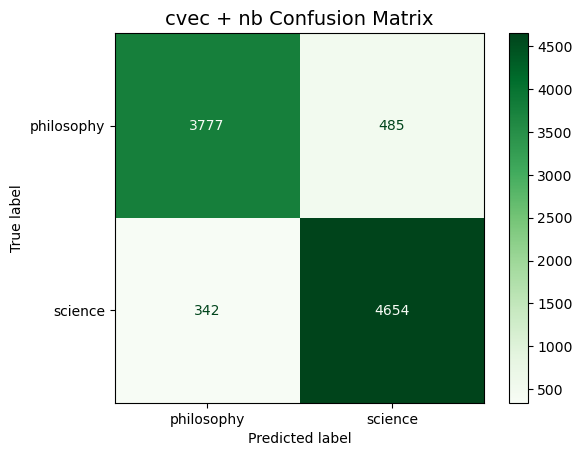

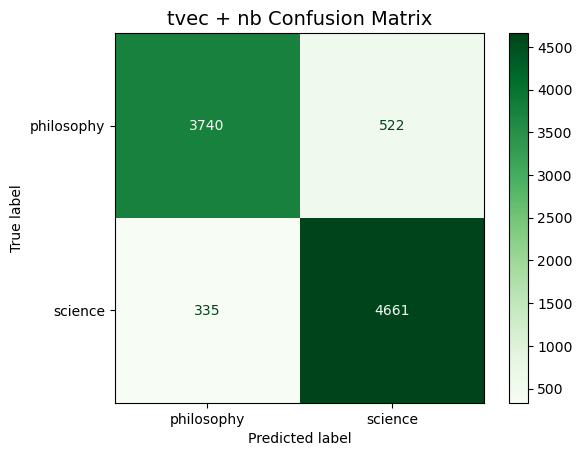

In [15]:
Results_nb = run_models(models = ['nb'])

2022/10/12 14:31:35 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '93849f1f82c14d9e839092e3731c53e5', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
/Users/mywk/mambaforge/envs/dsi-sg/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
450 fits failed out of a total of 2400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
450 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/mywk/mambaforge/envs/dsi-sg/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fil

------------------------------------
Model results: cvec_lr
------------------------------------


{'cvec__max_df': 0.7, 'cvec__max_features': 30000, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 1), 'lr__C': 1, 'lr__max_iter': 10000, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}


train accuracy: 0.9679710497177888
test accuracy: 0.9222294232015554


Accuracy: 0.9222294232015554
Recall: 0.9047237790232185
Precision: 0.9487825356842989
F1 Score: 0.9262295081967212




2022/10/12 14:37:04 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f97ed0116c3b49b1bdd33633ac307ef0', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
/Users/mywk/mambaforge/envs/dsi-sg/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
450 fits failed out of a total of 2400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
450 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/mywk/mambaforge/envs/dsi-sg/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fil

------------------------------------
Model results: tvec_lr
------------------------------------


{'lr__C': 1, 'lr__max_iter': 10000, 'lr__penalty': 'l2', 'lr__solver': 'saga', 'tvec__max_df': 0.9, 'tvec__max_features': 30000, 'tvec__min_df': 0.0001, 'tvec__ngram_range': (1, 1)}


train accuracy: 0.9442058926787112
test accuracy: 0.9181248649816375


Accuracy: 0.9181248649816375
Recall: 0.9161329063250601
Precision: 0.9310414971521562
F1 Score: 0.9235270379338175




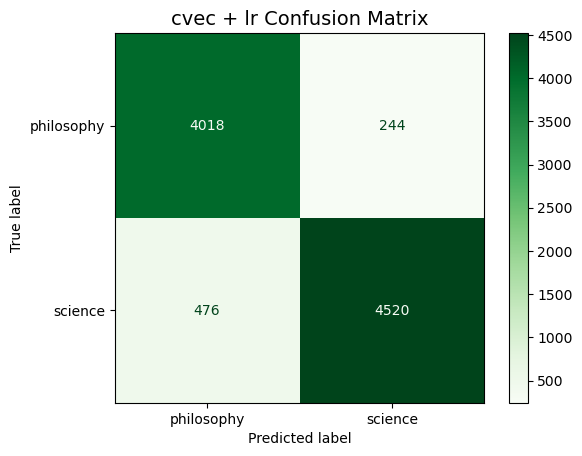

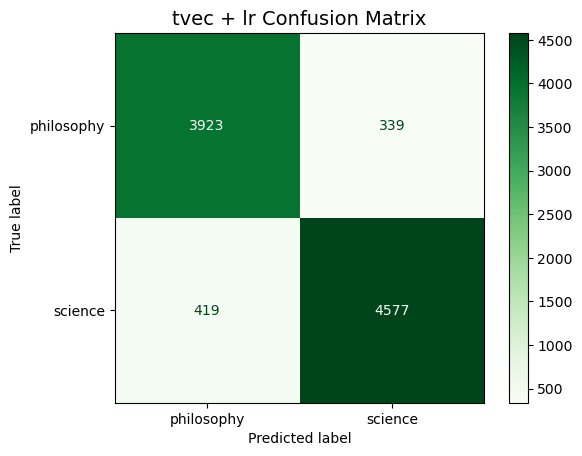

In [16]:
Results_lr = run_models(models = ['lr'])

2022/10/12 14:39:57 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '067943637aa24d6c99c5892352db6c46', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
/Users/mywk/mambaforge/envs/dsi-sg/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
135 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
135 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/mywk/mambaforge/envs/dsi-sg/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File

------------------------------------
Model results: cvec_rf
------------------------------------


{'cvec__max_df': 0.9, 'cvec__max_features': 30000, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 1), 'rf__max_depth': 50, 'rf__n_estimators': 150}


train accuracy: 0.9016176510302736
test accuracy: 0.87200259235256


Accuracy: 0.87200259235256
Recall: 0.8184547638110489
Precision: 0.936340737348294
F1 Score: 0.8734380006408202




2022/10/12 14:44:53 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '99fe314752434a739044b4ead0652f8a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
/Users/mywk/mambaforge/envs/dsi-sg/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
135 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
135 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/mywk/mambaforge/envs/dsi-sg/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File

------------------------------------
Model results: tvec_rf
------------------------------------


{'rf__max_depth': 50, 'rf__n_estimators': 150, 'tvec__max_df': 0.8, 'tvec__max_features': 30000, 'tvec__min_df': 1, 'tvec__ngram_range': (1, 1)}


train accuracy: 0.9079370223338464
test accuracy: 0.8737308273925254


Accuracy: 0.8737308273925254
Recall: 0.8194555644515612
Precision: 0.9387755102040817
F1 Score: 0.8750667949128994




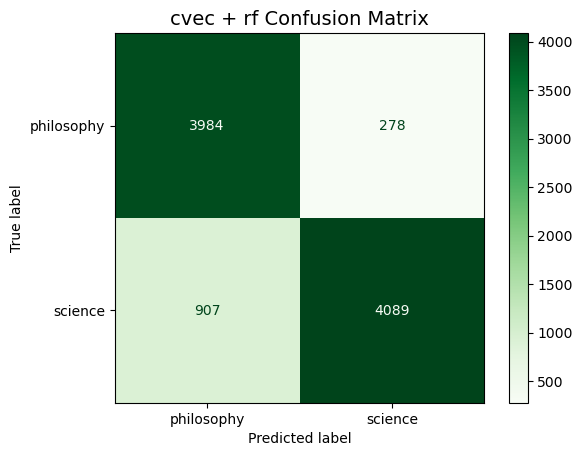

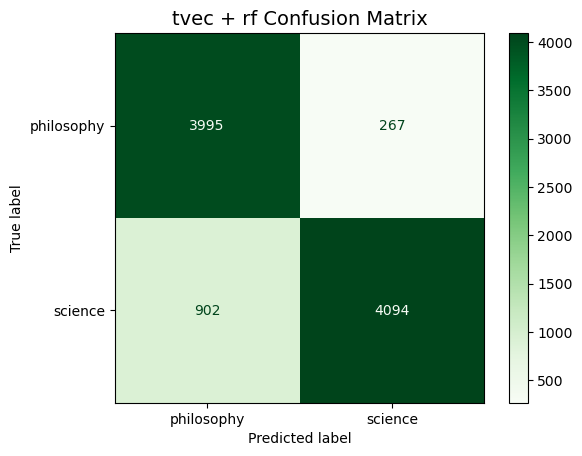

In [17]:
Results_rf = run_models(models = ['rf'])

2022/10/12 15:26:48 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '510fb357b6734fec9e012f1b35c8d47e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
/Users/mywk/mambaforge/envs/dsi-sg/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
135 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
135 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/mywk/mambaforge/envs/dsi-sg/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File

------------------------------------
Model results: cvec_et
------------------------------------


{'cvec__max_df': 0.9, 'cvec__max_features': 30000, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 1), 'et__max_depth': 50, 'et__n_estimators': 150}


train accuracy: 0.9325123551810743
test accuracy: 0.8917692806221647


Accuracy: 0.8917692806221647
Recall: 0.8714971977582066
Precision: 0.9236317352566822
F1 Score: 0.8968074150360453




2022/10/12 15:31:34 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '39114a6bdd404cb8a2b28aeb7e46974d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
/Users/mywk/mambaforge/envs/dsi-sg/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
135 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
135 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/mywk/mambaforge/envs/dsi-sg/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File

------------------------------------
Model results: tvec_et
------------------------------------


{'et__max_depth': 50, 'et__n_estimators': 150, 'tvec__max_df': 0.8, 'tvec__max_features': 30000, 'tvec__min_df': 1, 'tvec__ngram_range': (1, 1)}


train accuracy: 0.9447460098841448
test accuracy: 0.8965219269820696


Accuracy: 0.8965219269820696
Recall: 0.9079263410728583
Precision: 0.901072705601907
F1 Score: 0.9044865403788633




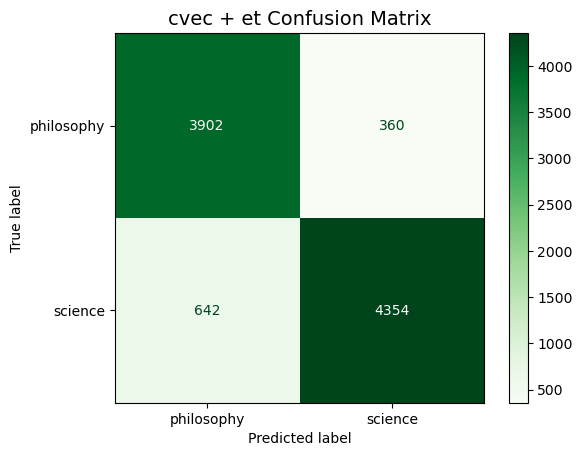

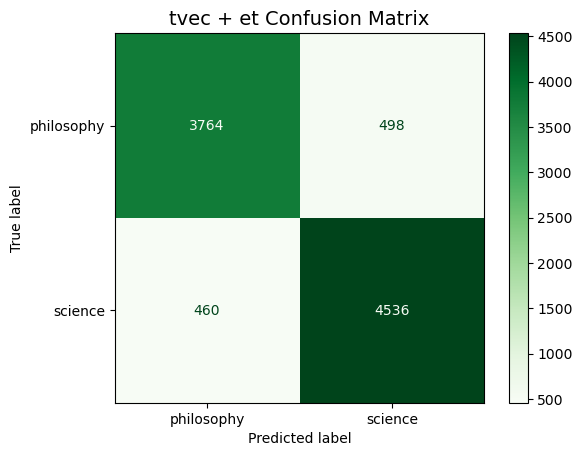

In [21]:
Results_et = run_models(models = ['et'])

### 3.3 Model Results
**Best Model: Logistic Regression with Count Vectorisation

In [22]:
# Saving model run results
Results = pd.DataFrame(columns = ['Model', 
                                  'Train_Acc', # Train Accuracy
                                  'Test_Acc', # Test Accuracy
                                  'Test_Prec', # Test Precision
                                  'Test_Rec', # Test Recall
                                  'Test_F1',
                                  'Best_Params' # Best Parameters
                                 ])

for model in model_dict.keys():
    try: Results = pd.concat([Results,globals()['Results_'+model]])
    except: pass

Results = Results.sort_values(by = ['Test_Acc'], ascending = False).reset_index().drop(columns = 'index')
Results

,Model,Train_Acc,Test_Acc,Test_Prec,Test_Rec,Test_F1,Best_Params
0,cvec_lr,0.967971,0.922229,0.948783,0.904724,0.92623,"{'cvec__max_df': 0.7, 'cvec__max_features': 30..."
1,tvec_lr,0.944206,0.918125,0.931041,0.916133,0.923527,"{'lr__C': 1, 'lr__max_iter': 10000, 'lr__penal..."
2,cvec_nb,0.944395,0.910672,0.905624,0.931545,0.918402,"{'cvec__max_df': 0.7, 'cvec__max_features': 30..."
3,tvec_nb,0.94958,0.907431,0.899286,0.932946,0.915807,"{'nb__alpha': 0.1, 'tvec__max_df': 0.7, 'tvec_..."
4,tvec_et,0.944746,0.896522,0.901073,0.907926,0.904487,"{'et__max_depth': 50, 'et__n_estimators': 150,..."
5,cvec_et,0.932512,0.891769,0.923632,0.871497,0.896807,"{'cvec__max_df': 0.9, 'cvec__max_features': 30..."
6,tvec_rf,0.907937,0.873731,0.938776,0.819456,0.875067,"{'rf__max_depth': 50, 'rf__n_estimators': 150,..."
7,cvec_rf,0.901618,0.872003,0.936341,0.818455,0.873438,"{'cvec__max_df': 0.9, 'cvec__max_features': 30..."


In [46]:
# Export Results
Results.to_csv('Datasets/Results.csv')


In [24]:
# Best Params
Results.loc[0,'Best_Params']


{'cvec__max_df': 0.7,
 'cvec__max_features': 30000,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'lr__C': 1,
 'lr__max_iter': 10000,
 'lr__penalty': 'l2',
 'lr__solver': 'liblinear'}

**Conclusion**  
Based on test accuracy, **Logistic Regression** with **Count Vectorisation** will be chosen as the best model for distinguishing between subreddits.

### 3.4 Best Model

In [25]:
# Best model - Instantiate
pipe_cvec_lr_b = Pipeline([('cvec_b', CountVectorizer()),
                            ('lr_b',LogisticRegression())])

param_best = {'cvec_b__max_features': [20_000],
              'cvec_b__min_df': [0.0001], 
              'cvec_b__max_df': [0.7],
              'cvec_b__ngram_range': [(1, 1)],
              'lr_b__C': [1],
              'lr_b__max_iter': [10000],
              'lr_b__penalty': ['l2'],
              'lr_b__solver': ['liblinear']
             }

cvec_lr_b = GridSearchCV(estimator = pipe_cvec_lr_b,
                          param_grid = param_best,
                          cv = 5,
                          n_jobs = -1,
                          verbose = 0)


In [27]:
# Best Model - Fit
cvec_lr_b.fit(X_train,y_train)


2022/10/12 15:40:56 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '10749b6962ba492e8a8f8c520a2f3d5c', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2022/10/12 15:41:01 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec_b', CountVectorizer()),
                                       ('lr_b', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'cvec_b__max_df': [0.7],
                         'cvec_b__max_features': [20000],
                         'cvec_b__min_df': [0.0001],
                         'cvec_b__ngram_range': [(1, 1)], 'lr_b__C': [1],
                         'lr_b__max_iter': [10000], 'lr_b__penalty': ['l2'],
                         'lr_b__solver': ['liblinear']})

Accuracy: 0.9214733203715705
Recall: 0.9043234587670136
Precision: 0.9477658904971681
F1 Score: 0.9255351838574208


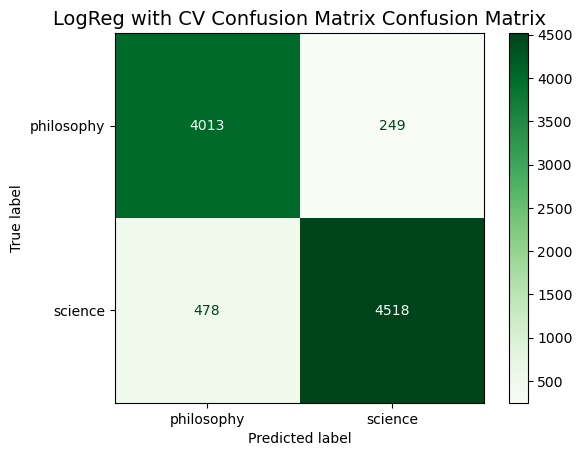

In [28]:
print_metrics(cvec_lr_b,'LogReg with CV Confusion Matrix',X_test,y_test)